# Link Unet Membrane
https://www.kaggle.com/datasets/tasmiarahmanaanika/unet-lung-mask

# Load Dataset Training dan Valid

In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow as tf
import keras.backend as K

from glob import glob
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

In [2]:
# Function to replace NaN values with 0
def replace_nan_with_zero(df, columns=None, inplace=True):
    """
    Replace NaN values with 0 in a DataFrame safely.

    Args:
        df: pandas DataFrame to operate on.
        columns: list of columns to target, or None for all columns.
        inplace: whether to modify the DataFrame in place (default True).

    Returns:
        If inplace is False: returns a new DataFrame with NaNs replaced, otherwise returns None.
    """
    if columns is None:
        if inplace:
            df.fillna(0, inplace=True)
            return None
        else:
            return df.fillna(0)
    else:
        # limit replacement only to the specified columns
        if inplace:
            df[columns] = df[columns].fillna(0)
            return None
        else:
            new_df = df.copy()
            new_df[columns] = new_df[columns].fillna(0)
            return new_df

In [3]:
# Number of rows to sample
n_rows = 35000

# Read and sample randomly
train_df = pd.read_csv("train.csv")
train_df.drop(columns=['_id'], inplace=True, errors='ignore')
train_df = train_df.sample(n=n_rows, random_state=42) 
train_df = train_df.reset_index(drop=True) 
train_df.head()

,Path,Sex,Age,Frontal_Lateral,AP_PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,D:/Downloads/train/patient00082/study1/view1_f...,Male,18,Frontal,PA,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,D:/Downloads/train/patient35759/study9/view1_f...,Male,90,Frontal,AP,0,0,1,0,0,1,0,0,1,0,0,0,0,1
2,D:/Downloads/train/patient04789/study1/view2_l...,Male,39,Lateral,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,D:/Downloads/train/patient38491/study5/view1_f...,Male,60,Frontal,AP,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,D:/Downloads/train/patient06537/study3/view1_f...,Female,66,Frontal,AP,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [4]:
train_df.to_csv("output.csv", index=False)

In [5]:
# Function to prepare dataset based on labeling policy 
def prepare_dataset(dataframe, policy, class_names):
    df = dataframe.sample(frac=1.0, random_state=1)
    x_path = df["Path"].to_numpy()
    
    y_df = df[class_names]
    
    class_ones = ['Atelectasis', 'Cardiomegaly'] 
    y = np.empty(y_df.shape, dtype=int)
    
    for i, (_, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            feat_val = 0

            if curr_val is not None:
                try:
                    curr_val = float(curr_val)
                except:
                    curr_val = 0

                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    if policy == "ones":
                        feat_val = 1
                    elif policy == "zeroes":
                        feat_val = 0
                    elif policy == "mixed":
                        feat_val = 1 if cls in class_ones else 0
                else:
                    feat_val = 0
            labels.append(feat_val)
        y[i] = labels
    
    return x_path, y


In [6]:
# Classes used based on CheXpert paper
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = prepare_dataset(train_df,policy[-1],class_names)

In [7]:
print(x_path)

['D:/Downloads/train/patient11143/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient26718/study3/view1_frontal.jpg'
 'D:/Downloads/train/patient56062/study1/view1_frontal.jpg' ...
 'D:/Downloads/train/patient02044/study2/view1_frontal.jpg'
 'D:/Downloads/train/patient28153/study11/view1_frontal.jpg'
 'D:/Downloads/train/patient36180/study9/view1_frontal.jpg']


In [8]:
# Get data
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2 

In [9]:
train_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/train/patient11143/study1/view1_f...,0,0,0,0,0
1,D:/Downloads/train/patient26718/study3/view1_f...,0,0,0,1,1
2,D:/Downloads/train/patient56062/study1/view1_f...,0,0,0,0,0
3,D:/Downloads/train/patient34151/study1/view2_l...,0,0,0,0,0
4,D:/Downloads/train/patient39422/study18/view1_...,0,0,0,1,0
...,...,...,...,...,...,...
34995,D:/Downloads/train/patient41032/study2/view1_f...,0,1,0,0,0
34996,D:/Downloads/train/patient39246/study6/view1_f...,1,0,0,0,1
34997,D:/Downloads/train/patient02044/study2/view1_f...,0,1,0,1,1
34998,D:/Downloads/train/patient28153/study11/view1_...,0,0,0,1,0


Clean Labels Summary:
Pleural_Effusion    13454
Atelectasis         10491
Edema                8085
Cardiomegaly         5475
Consolidation        2275
dtype: int64


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4],
  [Text(0, 0, 'Pleural_Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Cardiomegaly'),
   Text(4, 0, 'Consolidation')]))

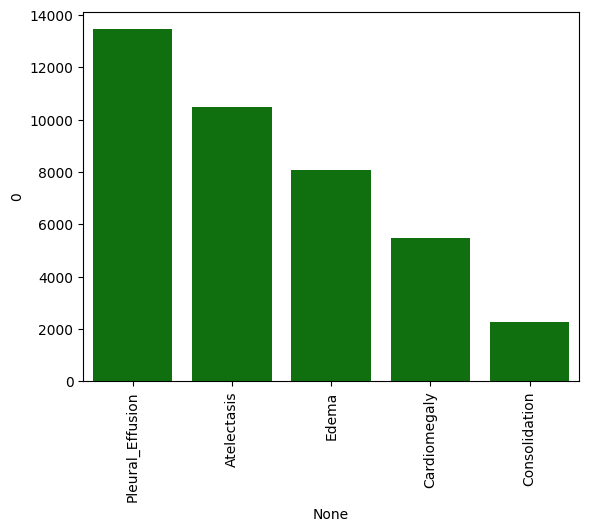

In [10]:
print("Clean Labels Summary:")
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [11]:
# get valid dataset
valid_df = pd.read_csv("valid.csv")
valid_df.drop(columns=['_id'], inplace=True, errors='ignore')
# Replace any NaNs with 0 
replace_nan_with_zero(valid_df)
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
my_glob_valid = [x.replace('\\', '/') for x in glob('D:/Downloads/valid/patient*/study*/*.jpg')]
print('Number of Observations: ', len(my_glob_valid)) 

Number of Observations:  234


In [13]:
images_directory_valid = "D:/Downloads/valid"

full_img_paths = {}

# Full image mapping (source images)
for x in my_glob_valid:
    rel_path = os.path.relpath(x, images_directory_valid)
    key = 'CheXpert-v1.0-small/valid/' + rel_path.replace('\\', '/')
    full_img_paths[key] = x.replace('\\', '/')
    
# Map the correct paths to the dataframe
valid_df['Path'] = valid_df['Path'].map(full_img_paths.get)
valid_df.columns = valid_df.columns.str.replace(' ', '_')

In [14]:
valid_x_path,valid_labels = prepare_dataset(valid_df,policy[-1],class_names)

In [15]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2 = pd.DataFrame(labels,columns=class_names)
valid_df[list(df2.columns)]=df2 
valid_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/valid/patient64706/study1/view1_f...,0,0,0,0,0
1,D:/Downloads/valid/patient64592/study1/view1_f...,0,0,0,1,1
2,D:/Downloads/valid/patient64740/study1/view1_f...,0,0,0,0,0
3,D:/Downloads/valid/patient64570/study1/view1_f...,0,0,0,0,0
4,D:/Downloads/valid/patient64647/study1/view1_f...,0,0,0,1,0
...,...,...,...,...,...,...
229,D:/Downloads/valid/patient64710/study1/view1_f...,1,1,0,1,1
230,D:/Downloads/valid/patient64646/study1/view1_f...,0,0,1,0,1
231,D:/Downloads/valid/patient64594/study1/view2_l...,0,0,0,0,0
232,D:/Downloads/valid/patient64649/study1/view1_f...,0,0,0,0,0


In [16]:
my_glob_train = train_df['path'].tolist()
print('Number of Observations: ', len(my_glob_train)) 

Number of Observations:  35000


In [17]:
print(my_glob_train)

['D:/Downloads/train/patient11143/study1/view1_frontal.jpg', 'D:/Downloads/train/patient26718/study3/view1_frontal.jpg', 'D:/Downloads/train/patient56062/study1/view1_frontal.jpg', 'D:/Downloads/train/patient34151/study1/view2_lateral.jpg', 'D:/Downloads/train/patient39422/study18/view1_frontal.jpg', 'D:/Downloads/train/patient49897/study1/view1_frontal.jpg', 'D:/Downloads/train/patient43420/study8/view1_frontal.jpg', 'D:/Downloads/train/patient27776/study1/view1_frontal.jpg', 'D:/Downloads/train/patient21993/study3/view1_frontal.jpg', 'D:/Downloads/train/patient47796/study1/view1_frontal.jpg', 'D:/Downloads/train/patient28261/study3/view1_frontal.jpg', 'D:/Downloads/train/patient16027/study4/view2_lateral.jpg', 'D:/Downloads/train/patient39105/study2/view1_frontal.jpg', 'D:/Downloads/train/patient13367/study5/view1_frontal.jpg', 'D:/Downloads/train/patient31503/study2/view1_frontal.jpg', 'D:/Downloads/train/patient57298/study1/view1_frontal.jpg', 'D:/Downloads/train/patient15698/study

# Resize Gambar

In [18]:
import cv2
import numpy as np

# function to resize input image with padding
def resize_with_padding(img, target_size=224, pad_color=0):
    h, w = img.shape[:2]

    # Scale with ratio maintained
    if h > w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding
    pad_vert = target_size - new_h
    pad_horz = target_size - new_w

    top = pad_vert // 2
    bottom = pad_vert - top
    left = pad_horz // 2
    right = pad_horz - left

    # Add padding
    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=pad_color,
    )

    return padded


In [19]:
def get_all_images(root_dir):
    exts = [".png", ".jpg", ".jpeg", ".bmp"]
    collected = []

    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if any(f.lower().endswith(e) for e in exts):
                collected.append(os.path.join(root, f))

    return collected

Pengaturan Direktori dan Resize Gambar

In [20]:
import cv2
from tqdm import tqdm

# resized directory 
resized_valid = "D:/Downloads/valid_resized"
resized_train = "D:/Downloads/train_resized"

TARGET_SIZE = 256
PAD_COLOR = 0 

In [21]:
def resize_images(my_glob, resized_output_dir):
    processed = 0
    failed = 0
    
    os.makedirs(resized_output_dir, exist_ok=True)
    
    glob = []
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(resized_output_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions:
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} resized images.")
        return glob
    else:
        print("No resized images found.")

        for img_path in tqdm(my_glob, desc="Resizing images"):
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"Failed to read image: {img_path}")
                failed += 1
                continue

            resized_img = resize_with_padding(img, target_size=TARGET_SIZE, pad_color=PAD_COLOR)

            # Build relative path from the glob path
            parts = img_path.replace("\\", "/").split("/")
            rel = "/".join(parts[3:])  # keep everything after the top-level folder

            out_path = os.path.join(resized_output_dir, rel)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            if resized_img.dtype != np.uint8:
                max_val = resized_img.max() or 1.0
                if max_val <= 1.0:
                    save_img = (resized_img * 255).astype(np.uint8)
                else:
                    save_img = resized_img.astype(np.uint8)
            else:
                save_img = resized_img

            success = cv2.imwrite(out_path, save_img)
            if not success:
                print(f"Failed to save: {out_path}")
                failed += 1
                continue
            
            processed += 1
            glob.append(out_path)
            
        print(f"Done. Processed: {processed}, Failed: {failed}")    
        return glob


In [22]:
glob_valid_resize = resize_images(my_glob_valid, resized_valid)

Found 234 resized images.


In [ ]:
glob_train_resize = resize_images(my_glob_train, resized_train)

No resized images found.


Resizing images:  66%|██████▋   | 23212/35000 [03:44<02:50, 69.28it/s] 

In [ ]:
print(glob_valid_resize)

In [ ]:
print(glob_train_resize)

In [ ]:
def replace_path(dataframe, glob):
    mapping = {}
    for path, new_path in zip(dataframe['path'], glob):
        mapping[path.replace("\\", "/")] = new_path.replace("\\", "/")
        
    dataframe['path'] = dataframe['path'].map(mapping.get)
    return dataframe

In [ ]:
valid_df = replace_path(valid_df, glob_valid_resize)
valid_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/valid_resized/patient64541/study1...,0,0,0,0,0
1,D:/Downloads/valid_resized/patient64542/study1...,0,0,0,1,1
2,D:/Downloads/valid_resized/patient64542/study1...,0,0,0,0,0
3,D:/Downloads/valid_resized/patient64543/study1...,0,0,0,0,0
4,D:/Downloads/valid_resized/patient64544/study1...,0,0,0,1,0
...,...,...,...,...,...,...
229,D:/Downloads/valid_resized/patient64736/study1...,1,1,0,1,1
230,D:/Downloads/valid_resized/patient64737/study1...,0,0,1,0,1
231,D:/Downloads/valid_resized/patient64738/study1...,0,0,0,0,0
232,D:/Downloads/valid_resized/patient64739/study1...,0,0,0,0,0


In [ ]:
train_df = replace_path(train_df, glob_train_resize)
train_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/train_resized/patient14339/study4...,0,0,0,0,0
1,D:/Downloads/train_resized/patient33200/study1...,0,0,0,0,1
2,D:/Downloads/train_resized/patient13227/study1...,0,0,0,0,0
3,D:/Downloads/train_resized/patient37912/study1...,0,0,0,1,0
4,D:/Downloads/train_resized/patient32046/study3...,1,0,0,0,1
...,...,...,...,...,...,...
9995,D:/Downloads/train_resized/patient00674/study2...,1,0,0,1,1
9996,D:/Downloads/train_resized/patient41032/study2...,0,1,0,0,0
9997,D:/Downloads/train_resized/patient48113/study1...,0,0,0,0,0
9998,D:/Downloads/train_resized/patient02044/study2...,0,1,0,1,1


# Load Model

In [ ]:
from keras.models import load_model

mask_model = load_model("unet_membrane_a6.hdf5")
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(mask_model.input_shape)

(None, 256, 256, 1)


In [ ]:
mask_output_valid = "D:/Downloads/masks/valid"
mask_output_train = "D:/Downloads/masks/train"

# Membuat Mask untuk Gambar

In [ ]:
def preprocess_image(file_path, target_size=(256, 256)):
    img = cv2.imread(file_path)
    if img is None:
        print(f"Error: Unable to read image at {file_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = cv2.equalizeHist(img)   # improve contrast
    img = cv2.GaussianBlur(img, (5,5), 0)  # reduce noise
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [ ]:
def predict_mask(model, image, verbose=0): 
    pred = model.predict(image, verbose=verbose) * 255
    return pred

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def predict_mask_image(path_glob, output_directory):
    glob = []
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(output_directory):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_mask"):
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} masks.")
        return glob
    else:
        print("No mask found.")
        for image_path in tqdm(path_glob, desc="Generating masks", unit="img" ):
            test_im = preprocess_image(image_path)
            if test_im is None:
                tqdm.write(f"Failed to preprocess: {image_path}")
                continue

            try:
                mask = predict_mask(mask_model, test_im, verbose=0)

                relative_path = os.path.relpath(image_path, images_directory)
                mask_path = os.path.join(output_directory, relative_path)

                directory, filename = os.path.split(mask_path)
                name, ext = os.path.splitext(filename)
                mask_filename = f"{name}_mask{ext}"
                mask_path = os.path.join(directory, mask_filename)

                os.makedirs(directory, exist_ok=True)

                mask_to_save = mask[0, :, :, 0]

                se_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                se_5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
                dst_dilate_inv = cv2.dilate(mask_to_save, se_3, iterations = 1)
                dst_erosi_inv = cv2.erode(dst_dilate_inv, se_3, iterations = 2)
                dst_dilate2_inv = cv2.dilate(dst_erosi_inv, se_5, iterations = 2)
                dst_erosi2_inv = cv2.erode(dst_dilate2_inv, se_5, iterations = 3)
                dst_dilate3_inv = cv2.dilate(dst_erosi2_inv, se_3, iterations = 1)
                mask_to_save = dst_dilate3_inv

                if mask_to_save.dtype != np.uint8:
                    if mask_to_save.max() <= 1.0:
                        mask_to_save = (mask_to_save * 255).astype(np.uint8)
                    else:
                        mask_to_save = mask_to_save.astype(np.uint8)

                if cv2.imwrite(mask_path, mask_to_save):
                    glob.append(mask_path)
                else:
                    tqdm.write(f"Failed to save: {mask_path}")

            except Exception as e:
                tqdm.write(f"Error processing {image_path}: {e}")

        return glob


Creating masks from training and validation dataset

In [ ]:
mask_glob_train = predict_mask_image(glob_train_resize, mask_output_train)

NameError: name 'glob_train_resize' is not defined

In [ ]:
mask_glob_valid = predict_mask_image(glob_valid_resize, mask_output_valid)

Found 234 masks.


In [ ]:
print(mask_glob_valid)

In [ ]:
print(mask_glob_train)

show 5 random original images and their masks

In [ ]:
import os
import random
import math
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def _make_key(path, levels=3):
    """
    Build a matching key from the last `levels` path segments.
    Example: .../patient64541/study1/view1_frontal.jpg  ->  patient64541/study1/view1_frontal
    """
    p = Path(os.path.normpath(path))
    parts = [part for part in p.parts if part not in (".", "..")]
    if len(parts) == 0:
        return ""
    last = parts[-levels:]
    # replace final segment with its stem (no extension)
    last[-1] = Path(last[-1]).stem
    return "/".join(last)

def display_resized_samples(image_glob, mask_glob, num_samples=10, key_levels=3, random_seed=None):
    """
    Display paired resized images and masks using robust keys that include patient folders
    image_glob: list of image paths
    mask_glob: list of mask paths (mask filenames include _mask)
    num_samples: how many pairs to show
    key_levels: how many trailing path segments to use for the matching key
    """
    if random_seed is not None:
        random.seed(random_seed)

    # normalize paths and build mask lookup by key
    image_glob = [os.path.normpath(p).replace("\\", "/") for p in image_glob]
    mask_glob = [os.path.normpath(p).replace("\\", "/") for p in mask_glob]

    mask_dict = {}
    for m in mask_glob:
        key = _make_key(m, levels=key_levels)
        # remove trailing "_mask" from the file-stem part of the key if present
        if key.endswith("_mask"):
            key = key[:-5]
        mask_dict[key] = m

    # limit samples
    num_samples = min(num_samples, len(image_glob))
    samples = random.sample(image_glob, num_samples)

    num_columns = 2
    num_rows = num_samples

    plt.figure(figsize=(12, num_rows * 3))

    for i, img_path in enumerate(samples, start=1):
        key = _make_key(img_path, levels=key_levels)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception:
            img_rgb = img

        mask_path = mask_dict.get(key)
        mask = None
        if mask_path:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Found mask path but failed to read mask: {mask_path}")

        print(f"[{i}] image: {img_path}")
        print(f"[{i}] key: {key}")
        print(f"[{i}] mask: {mask_path if mask_path else 'NOT FOUND'}")

        # plot image
        plt.subplot(num_rows, num_columns, 2*i - 1)
        plt.imshow(img_rgb)
        plt.title("Resized Image")
        plt.axis("off")

        # plot mask or placeholder
        plt.subplot(num_rows, num_columns, 2*i)
        if mask is not None:
            plt.imshow(mask, cmap="gray")
            plt.title("Resized Mask")
        else:
            plt.text(0.5, 0.5, "Mask not found", ha="center", va="center", fontsize=12)
            plt.title("Missing Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


[1] image: D:/Downloads/valid_resized/patient64716/study1/view1_frontal.jpg
[1] key: patient64716/study1/view1_frontal
[1] mask: D:/Downloads/masks/valid_resized/patient64716/study1/view1_frontal_mask.jpg
[2] image: D:/Downloads/valid_resized/patient64594/study1/view1_frontal.jpg
[2] key: patient64594/study1/view1_frontal
[2] mask: D:/Downloads/masks/valid_resized/patient64594/study1/view1_frontal_mask.jpg
[3] image: D:/Downloads/valid_resized/patient64667/study1/view1_frontal.jpg
[3] key: patient64667/study1/view1_frontal
[3] mask: D:/Downloads/masks/valid_resized/patient64667/study1/view1_frontal_mask.jpg
[4] image: D:/Downloads/valid_resized/patient64596/study1/view1_frontal.jpg
[4] key: patient64596/study1/view1_frontal
[4] mask: D:/Downloads/masks/valid_resized/patient64596/study1/view1_frontal_mask.jpg
[5] image: D:/Downloads/valid_resized/patient64640/study1/view1_frontal.jpg
[5] key: patient64640/study1/view1_frontal
[5] mask: D:/Downloads/masks/valid_resized/patient64640/study

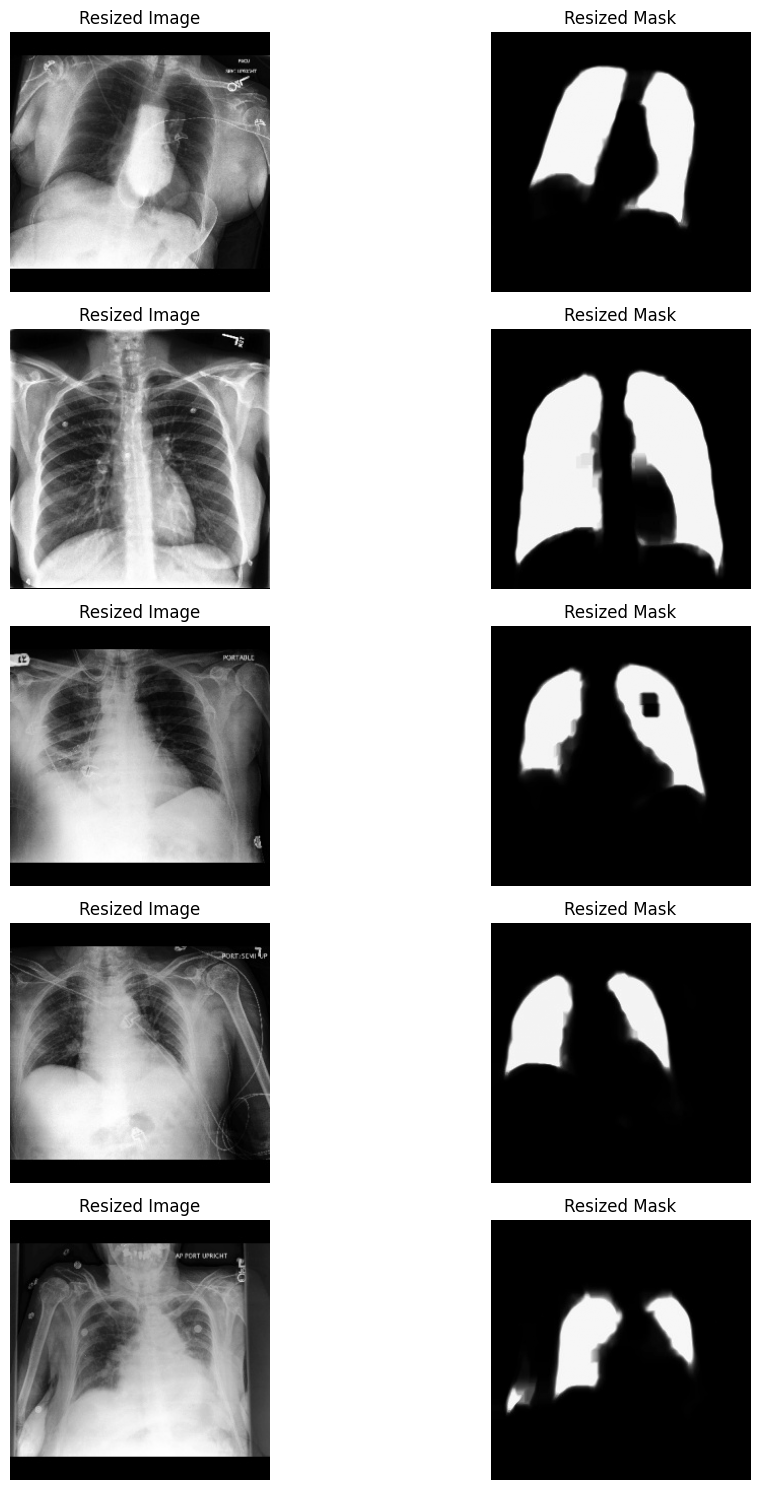

In [ ]:
display_resized_samples(glob_valid_resize, mask_glob_valid, key_levels=3, num_samples=5)

[1] image: D:/Downloads/train_resized/patient03174/study1/view1_frontal.jpg
[1] key: patient03174/study1/view1_frontal
[1] mask: D:/Downloads/masks/train_resized/patient03174/study1/view1_frontal_mask.jpg
[2] image: D:/Downloads/train_resized/patient08393/study1/view2_lateral.jpg
[2] key: patient08393/study1/view2_lateral
[2] mask: D:/Downloads/masks/train_resized/patient08393/study1/view2_lateral_mask.jpg
[3] image: D:/Downloads/train_resized/patient01808/study10/view1_frontal.jpg
[3] key: patient01808/study10/view1_frontal
[3] mask: D:/Downloads/masks/train_resized/patient01808/study10/view1_frontal_mask.jpg
[4] image: D:/Downloads/train_resized/patient51335/study2/view1_frontal.jpg
[4] key: patient51335/study2/view1_frontal
[4] mask: D:/Downloads/masks/train_resized/patient51335/study2/view1_frontal_mask.jpg
[5] image: D:/Downloads/train_resized/patient50911/study1/view2_lateral.jpg
[5] key: patient50911/study1/view2_lateral
[5] mask: D:/Downloads/masks/train_resized/patient50911/st

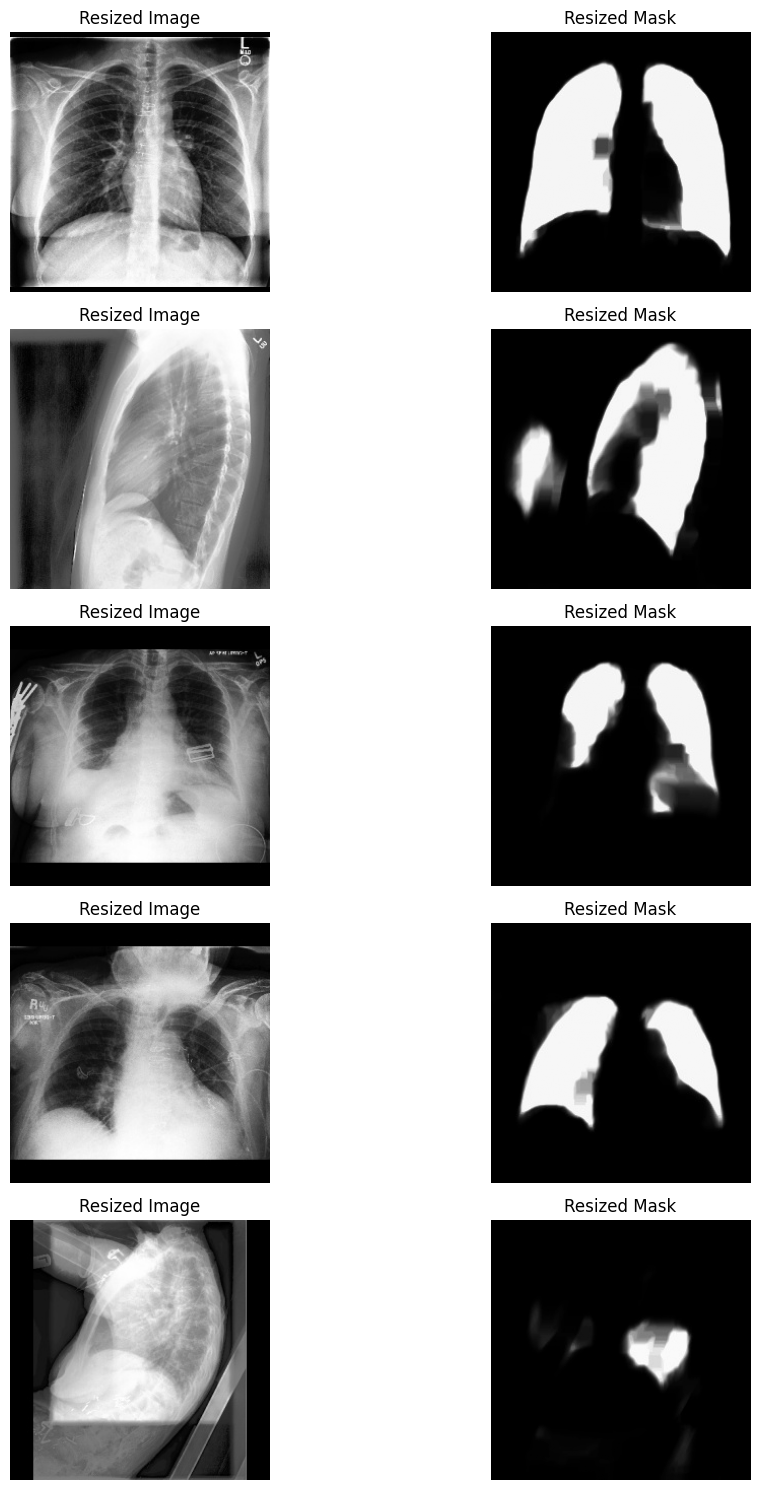

In [ ]:
display_resized_samples(glob_train_resize, mask_glob_train, key_levels=3, num_samples=5)

# Combining Mask with Original Image

In [ ]:
def bitwise_operation(mask_glob, resize_glob, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    glob = []
    
    for mask_path, image_path in zip(mask_glob, resize_glob):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None or image is None:
            print(f"Failed to read mask or image: {mask_path}, {image_path}")
            continue
        
        # Ensure mask is binary
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Apply bitwise AND operation
        result = cv2.bitwise_and(image, image, mask=binary_mask)
        
        # Build output path
        parts = image_path.replace("\\", "/").split("/")
        relative_path = "/".join(parts[3:])  # keep everything after the top-level folder
        output_path = os.path.join(output_directory, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        directory, filename = os.path.split(output_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_bitwise{ext}"
        output_path = os.path.join(directory, new_filename)
        
        # Save the result
        success = cv2.imwrite(output_path, result)
        if success:
            print(f"✓ Saved: {output_path}")
            glob.append(output_path)
        else:
            print(f"✗ Failed to save: {output_path}")
    
    return glob

In [ ]:
def check_bitwise_images(mask_glob, img_glob, root_dir):
    valid_extensions = {".jpg", ".jpeg", ".png"}
    found = []
    os.makedirs(root_dir, exist_ok=True)

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_bitwise"):
                found.append(os.path.join(root, file))
    
    if found:
        print(f"Found {len(found)} bitwise images.")
        return found
    else:
        print("No bitwise images found. Proceed to generate bitwise images.")
        return bitwise_operation(mask_glob, img_glob, root_dir)

In [ ]:
bitwise_output_valid = "D:/Downloads/bitwise_valid"
bitwise_glob_valid = check_bitwise_images(mask_glob_valid, glob_valid_resize, bitwise_output_valid)

No bitwise images found. Proceed to generate bitwise images.
✓ Saved: D:/Downloads/bitwise_valid\patient64541/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64542/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64542/study1\view2_lateral_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64543/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64544/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64545/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64546/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64547/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64547/study1\view2_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64547/study1\view3_lateral_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\patient64548/study1\view1_frontal_bitwise.jpg
✓ Saved: D:/Downloads/bitwise_valid\p

In [ ]:
bitwise_output_train = "D:/Downloads/bitwise_train"
bitwise_glob_train = check_bitwise_images(mask_glob_train, glob_train_resize, bitwise_output_train)

NameError: name 'mask_glob_train' is not defined

In [ ]:
print(bitwise_glob_valid)

In [ ]:
print(bitwise_glob_train)

In [ ]:
valid_df = replace_path(valid_df, bitwise_glob_valid)
valid_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/bitwise_valid/../valid_resized/pa...,0,0,0,0,0
1,D:/Downloads/bitwise_valid/../valid_resized/pa...,0,0,0,0,1
2,D:/Downloads/bitwise_valid/../valid_resized/pa...,0,0,0,0,0
3,D:/Downloads/bitwise_valid/../valid_resized/pa...,0,0,0,1,0
4,D:/Downloads/bitwise_valid/../valid_resized/pa...,1,0,0,0,1
...,...,...,...,...,...,...
229,D:/Downloads/bitwise_valid/../valid_resized/pa...,0,0,0,1,1
230,D:/Downloads/bitwise_valid/../valid_resized/pa...,1,0,0,0,0
231,D:/Downloads/bitwise_valid/../valid_resized/pa...,1,0,0,0,0
232,D:/Downloads/bitwise_valid/../valid_resized/pa...,1,1,1,1,1


In [ ]:
train_df = replace_path(train_df, bitwise_glob_train)
train_df 

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/bitwise_train/../train_resized/pa...,0,0,0,0,0
1,D:/Downloads/bitwise_train/../train_resized/pa...,0,0,0,0,1
2,D:/Downloads/bitwise_train/../train_resized/pa...,0,0,0,0,0
3,D:/Downloads/bitwise_train/../train_resized/pa...,0,0,0,1,0
4,D:/Downloads/bitwise_train/../train_resized/pa...,1,0,0,0,1
...,...,...,...,...,...,...
9995,D:/Downloads/bitwise_train/../train_resized/pa...,1,0,0,1,1
9996,D:/Downloads/bitwise_train/../train_resized/pa...,0,1,0,0,0
9997,D:/Downloads/bitwise_train/../train_resized/pa...,0,0,0,0,0
9998,D:/Downloads/bitwise_train/../train_resized/pa...,0,1,0,1,1


In [ ]:
IMG_SIZE = (224,224)
CHANNELS = 3

In [ ]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           shear_range=0.2,
                                                           zoom_range=0.2,
                                                           rotation_range=20,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           horizontal_flip=True)

train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         batch_size=16)

valid_gen = base_gen.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         batch_size=16)  


test_X, test_Y = next(base_gen.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col=class_names,
                                                   class_mode='raw',
                                                   target_size=IMG_SIZE,
                                                   shuffle = True,
                                                   batch_size=16))

Found 10000 validated image filenames.
Found 234 validated image filenames.
Found 234 validated image filenames.


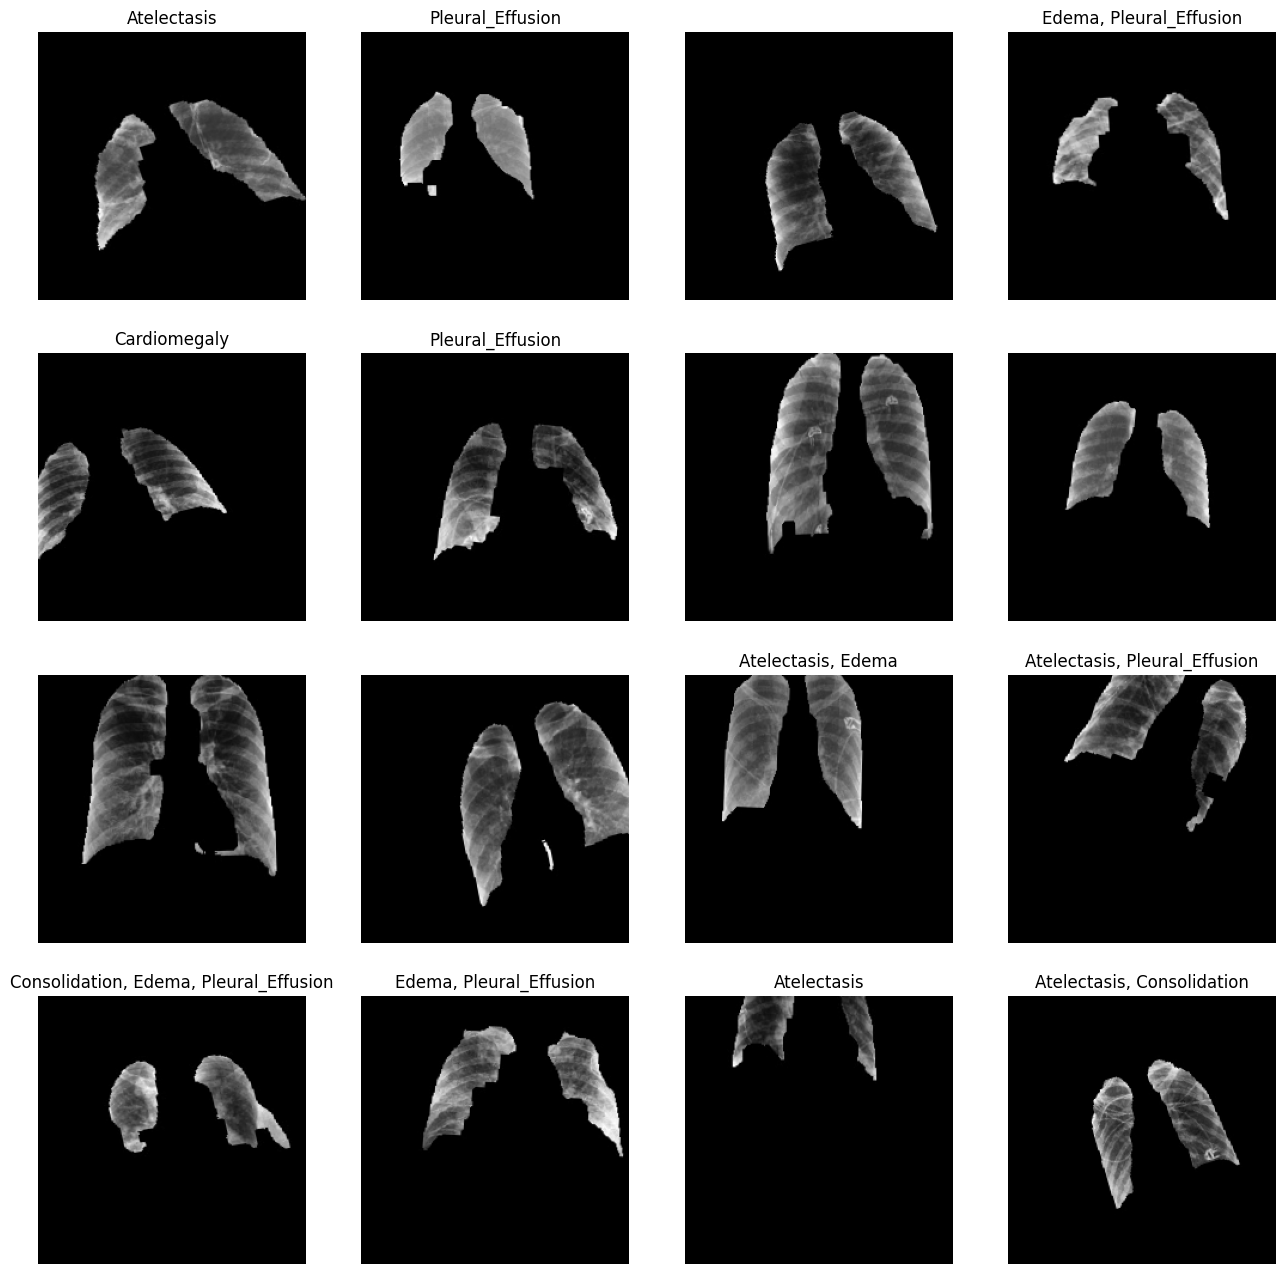

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,2], cmap='gray')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# DenseNet Model 

In [ ]:
#model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output  
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(class_names), activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
@tf.function
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    y = tf.cast(y, tf.float32)   # ✅ Add this line
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1


In [ ]:
#optimizer = tf.optimizers.RMSProp(learning_rate=0.001)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
model.compile(optimizer=optimizer, loss=macro_soft_f1, metrics=[macro_f1])

In [ ]:
H = model.fit(train_gen,validation_data=(test_X,test_Y),epochs=5)

c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 440ms/step - loss: 0.6450 - macro_f1: 0.3602 - val_loss: 0.6820 - val_macro_f1: 0.2940
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 329ms/step - loss: 0.6377 - macro_f1: 0.3655 - val_loss: 0.6667 - val_macro_f1: 0.3325
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 243s 389ms/step - loss: 0.6345 - macro_f1: 0.3692 - val_loss: 0.6719 - val_macro_f1: 0.3074
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 412ms/step - loss: 0.6325 - macro_f1: 0.3709 - val_loss: 0.6675 - val_macro_f1: 0.3134
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 411ms/step - loss: 0.6310 - macro_f1: 0.3716 - val_loss: 0.6604 - val_macro_f1: 0.3700


In [ ]:
model.save('DenseNet121.h5')

In [ ]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

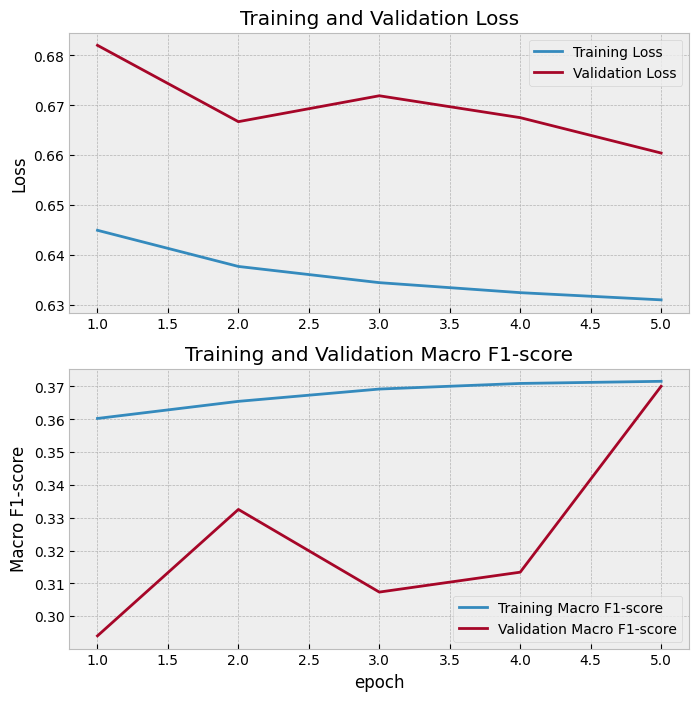

In [ ]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(H)

In [ ]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.66
Macro F1-score: 0.37


Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step
Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.14      0.29      0.18        35
   Consolidation       0.06      1.00      0.12        15
           Edema       0.22      0.38      0.28        60
Pleural_Effusion       0.43      1.00      0.60       100

       micro avg       0.25      0.78      0.38       286
       macro avg       0.23      0.73      0.33       286
    weighted avg       0.30      0.78      0.43       286
     samples avg       0.26      0.58      0.34       286

Macro F1 (sklearn): 0.33471618939514886
Micro F1 (sklearn): 0.38421955403087477


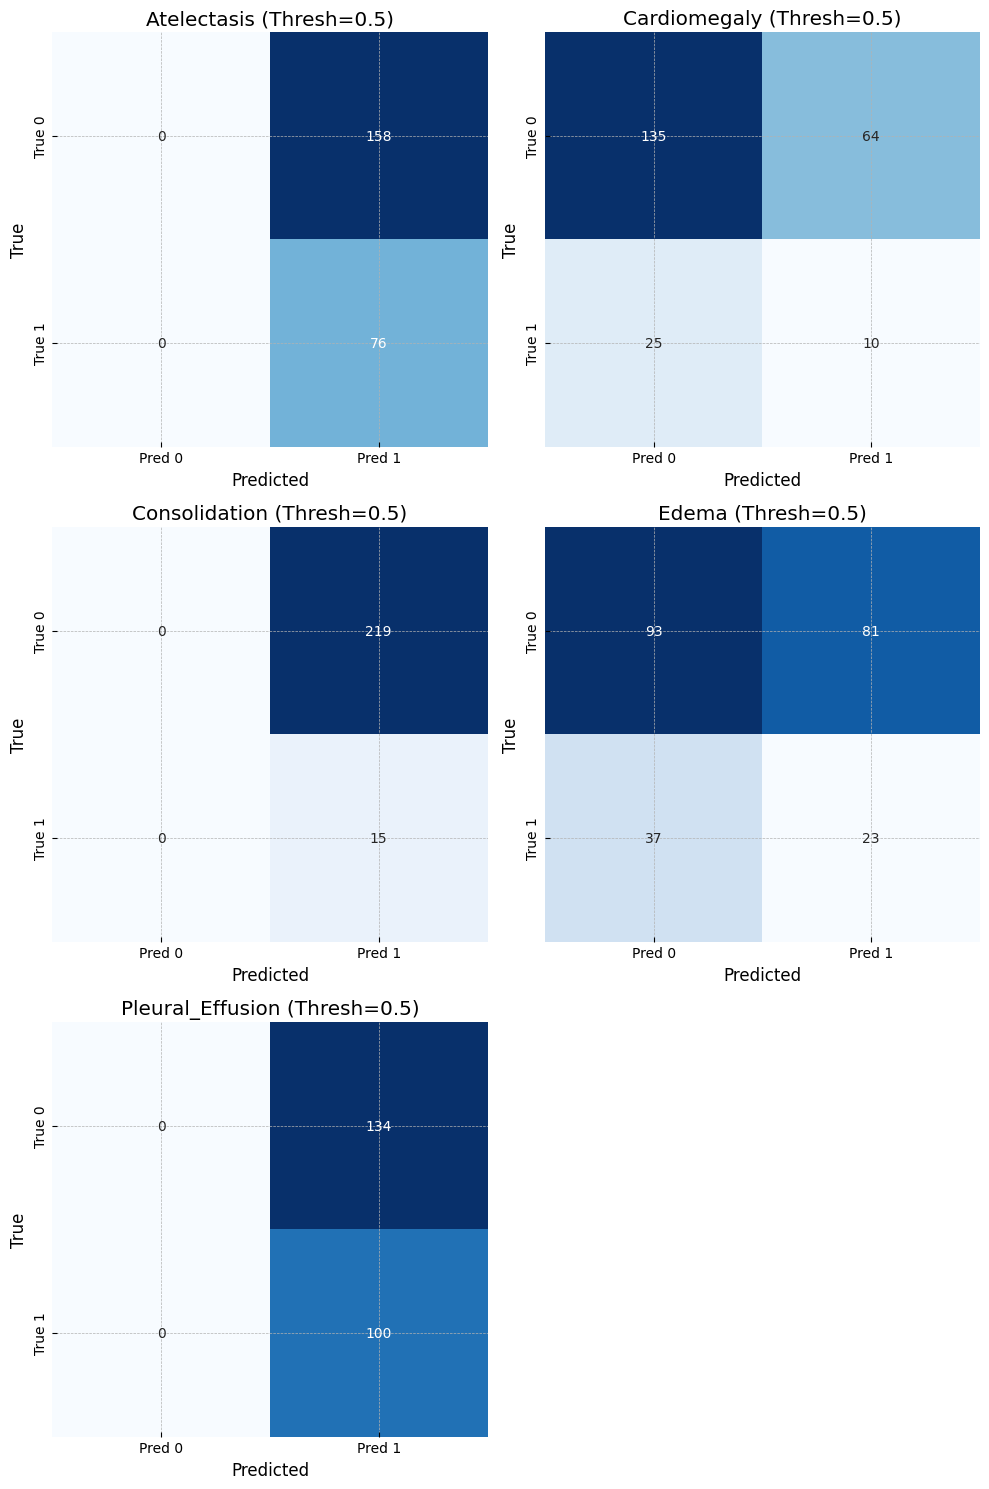

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import math

# Confusion matrices + heatmaps for multilabel DenseNet121 model on validation set

# ensure deterministic order for evaluation
BATCH_SIZE = 16
thresh = 0.5

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# predict probabilities for the whole validation set
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()
y_pred = (preds >= thresh).astype(int)

# overall multilabel reports
print("Classification report (per-class):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

print("Macro F1 (sklearn):", f1_score(y_true, y_pred, average='macro'))
print("Micro F1 (sklearn):", f1_score(y_true, y_pred, average='micro'))

# Plot 2x2 confusion matrix heatmaps for each class
n = len(class_names)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0,1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
                ax=axes[i])
    axes[i].set_title(f"{cls} (Thresh={thresh})")
    axes[i].set_ylabel("True")
    axes[i].set_xlabel("Predicted")

# hide any unused subplots
for j in range(n, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()